#### Deep Learning : AI2100

#### HW6

#### Tanmay Goyal- AI20BTECH11021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
import warnings
import pandas as pd
from PIL import Image
warnings.filterwarnings(action='ignore',)           # to get rid of TSNE warnings

datasource:  http://cs231n.stanford.edu/tiny-imagenet-200.zip

In [3]:
train_datapath = "tiny-imagenet-200/train"
val_datapath = "tiny-imagenet-200/val"


# reference: https://pytorch.org/hub/pytorch_vision_alexnet/

# defining transformations
transformation = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# loading training dataset
train_dataset = torchvision.datasets.ImageFolder(train_datapath ,  transform = transformation)
train_loader = DataLoader(train_dataset , batch_size = 5000 , shuffle = False)

training_dataset = []

# Since there are 500 images each of 200 classes, we can choose 100 from the first 10 classes each. 
# For this, we turn shuffle off
examples_train = iter(train_loader)
example_data_train, example_targets_train = examples_train.next()

for i in range(10):
    start = i * 500
    end = i * 500 + 100
    for j in range(start,end):
        training_dataset.append((example_data_train[j] , example_targets_train[j]))

In [4]:
# obtaining specific images in test set corresponding to first 10 classes

testing_dataset = []
test_labels = []

# reference: https://github.com/seshuad/IMagenet/blob/master/TinyImagenet.ipynb
val_data = pd.read_csv(val_datapath + '/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data

classes = ['n01443537' , 'n01629819' , 'n01641577' , 'n01644900' , 'n01698640' , 'n01742172' , 'n01742172' \
    , 'n01770393' , 'n01774384' , 'n01774750']

images = []

for c in classes:
    files = val_data[val_data['Class'] == c].sample(n = 10)
    for idx , row in files.iterrows():
        images.append(row['File'])

for image in images:
    i = Image.open(val_datapath + '/images/' +image)
    x = transformation(i)
    testing_dataset.append(x)

for i in range(10):
    for j in range(10):
        test_labels.append(torch.tensor(i))

##### ALEXNET

In [149]:
# Importing AlexNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
print(model)
print("The total parameters are {}".format(np.array([p.numel() for p in model.parameters()]).sum()))

Using cache found in /Users/tanmaygoyal/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch 1 : Training loss: 2.320497512817383 ; Testing Loss = 2.321706533432007
Epoch 2 : Training loss: 2.3087573051452637 ; Testing Loss = 2.3087570667266846
Epoch 3 : Training loss: 2.309572458267212 ; Testing Loss = 2.309572696685791
Epoch 4 : Training loss: 2.3081698417663574 ; Testing Loss = 2.3081696033477783
Epoch 5 : Training loss: 2.3053267002105713 ; Testing Loss = 2.3053267002105713
Epoch 6 : Training loss: 2.304823398590088 ; Testing Loss = 2.304823398590088
Epoch 7 : Training loss: 2.308032751083374 ; Testing Loss = 2.308032751083374
Epoch 8 : Training loss: 2.3041560649871826 ; Testing Loss = 2.3041560649871826
Epoch 9 : Training loss: 2.304508686065674 ; Testing Loss = 2.304509162902832
Epoch 10 : Training loss: 2.305309534072876 ; Testing Loss = 2.305309534072876
Epoch 11 : Training loss: 2.3039684295654297 ; Testing Loss = 2.3039684295654297
Epoch 12 : Training loss: 2.3055624961853027 ; Testing Loss = 2.3055624961853027
Epoch 13 : Training loss: 2.304677963256836 ; Tes

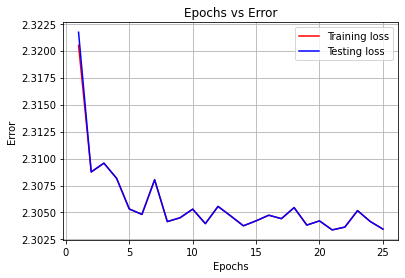

In [153]:
epochs = 25

# setting up optimizer
optimizer = torch.optim.Adam(params = model.parameters() ,lr = 0.01)

train_loss = []
test_loss = []
# tsne_first = []
# tsne_last = []

for e in range(epochs):
    batch_size = 100

    # number of batches per epoch
    counter = 1000 // batch_size

    # shuffling training data
    np.random.shuffle(training_dataset)

    for c in range(counter):
        
        # compiling batch_size number of images and labels
        x = []
        y = []
        for i in range(c * batch_size , (c+1) * batch_size):
            x.append(training_dataset[i][0])
            y.append(training_dataset[i][1])
        x = torch.stack(x)
        y = torch.stack(y)
        
        # computing output
        out = model(x)
            
        # computing loss
        loss = F.cross_entropy(out , y)
        
        # setting gradients to zero, calculating gradients and updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # computing training loss over entire training set
    train_x = []
    train_y = []
    for i in range(len(training_dataset)):
        train_x.append(training_dataset[i][0])
        train_y.append(training_dataset[i][1])
    train_x = torch.stack(train_x)
    train_y = torch.stack(train_y)
    
    output_train  = model(train_x)
    loss = F.cross_entropy(output_train , train_y)
    train_loss.append(loss.item())

    # computing testing loss over testing set
    test_x = []
    test_y = []
    for i in range(len(testing_dataset)):
        test_x.append(testing_dataset[i])
        test_y.append(test_labels[i])
    test_x = torch.stack(test_x)
    test_y = torch.stack(test_y)
    
    output_test  = model(test_x)
    loss = F.cross_entropy(output_test , test_y)
    test_loss.append(loss.item())

    print("Epoch {} : Training loss: {} ; Testing Loss = {}".format(e + 1 , train_loss[e] , test_loss[e]))
    if e == epochs - 1:
        accuracy = 0
        for i in range(len(testing_dataset)):
            pred = np.where(output_test[i , :] == output_test[i , :].max())[0][0]
            if pred == test_y[i]:
                accuracy += 1
        accuracy /= len(testing_dataset)
        print("The accuracy is: {}".format(accuracy))

# plotting errors vs epoch
x = [i for i in range(1,26)]
plt.plot(x , train_loss , 'r-' , label = "Training loss")
plt.plot(x , test_loss , 'b-' , label = "Testing loss")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.title("Epochs vs Error")
plt.show()  

        

##### RESNET50

In [9]:
train_datapath = "tiny-imagenet-200/train"
val_datapath = "tiny-imagenet-200/val"


# reference: https://pytorch.org/hub/pytorch_vision_alexnet/

# defining transformations
transformation = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# loading training dataset
train_dataset = torchvision.datasets.ImageFolder(train_datapath ,  transform = transformation)
train_loader = DataLoader(train_dataset , batch_size = 5000 , shuffle = False)

training_dataset = []

# Since there are 500 images each of 200 classes, we can choose 20 from the first 10 classes each. 
# For this, we turn shuffle off
examples_train = iter(train_loader)
example_data_train, example_targets_train = examples_train.next()

for i in range(10):
    start = i * 500
    end = i * 500 + 20
    for j in range(start,end):
        training_dataset.append((example_data_train[j] , example_targets_train[j]))

In [10]:
# obtaining specific images in test set corresponding to first 10 classes

testing_dataset = []
test_labels = []

# reference: https://github.com/seshuad/IMagenet/blob/master/TinyImagenet.ipynb
val_data = pd.read_csv(val_datapath + '/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data

classes = ['n01443537' , 'n01629819' , 'n01641577' , 'n01644900' , 'n01698640' , 'n01742172' , 'n01742172' \
    , 'n01770393' , 'n01774384' , 'n01774750']

images = []

for c in classes:
    files = val_data[val_data['Class'] == c].sample(n = 5)
    for idx , row in files.iterrows():
        images.append(row['File'])

for image in images:
    i = Image.open(val_datapath + '/images/' +image)
    x = transformation(i)
    testing_dataset.append(x)

for i in range(10):
    for j in range(10):
        test_labels.append(torch.tensor(i))

In [11]:
# Importing ResNet50
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
print(model)
print("The total parameters are {}".format(np.array([p.numel() for p in model.parameters()]).sum()))

Using cache found in /Users/tanmaygoyal/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch 1 : Training loss: 3.006577491760254 ; Testing Loss = 3.4109365940093994
Epoch 2 : Training loss: 2.3946990966796875 ; Testing Loss = 2.638331413269043
Epoch 3 : Training loss: 2.238510847091675 ; Testing Loss = 2.842190742492676
Epoch 4 : Training loss: 2.082059621810913 ; Testing Loss = 2.6816928386688232
Epoch 5 : Training loss: 2.2204537391662598 ; Testing Loss = 2.9511878490448
Epoch 6 : Training loss: 1.985196828842163 ; Testing Loss = 3.702307939529419
Epoch 7 : Training loss: 1.7766741514205933 ; Testing Loss = 3.435591459274292
Epoch 8 : Training loss: 1.5321005582809448 ; Testing Loss = 3.4806413650512695
Epoch 9 : Training loss: 1.5910781621932983 ; Testing Loss = 3.5814218521118164
Epoch 10 : Training loss: 1.6615067720413208 ; Testing Loss = 3.775883674621582
Epoch 11 : Training loss: 1.3706835508346558 ; Testing Loss = 3.500333309173584
Epoch 12 : Training loss: 1.2599940299987793 ; Testing Loss = 3.446096897125244
Epoch 13 : Training loss: 1.120658040046692 ; Testi

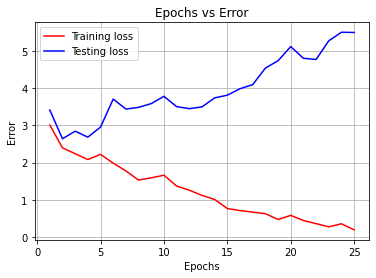

In [12]:
epochs = 25

# setting up optimizer
optimizer = torch.optim.Adam(params = model.parameters())

train_loss = []
test_loss = []
# tsne_first = []
# tsne_last = []

for e in range(epochs):
    batch_size = 50

    # number of batches per epoch
    counter = 100 // batch_size

    # shuffling training data
    np.random.shuffle(training_dataset)

    for c in range(counter):
        
        # compiling batch_size number of images and labels
        x = []
        y = []
        for i in range(c * batch_size , (c+1) * batch_size):
            x.append(training_dataset[i][0])
            y.append(training_dataset[i][1])
        x = torch.stack(x)
        y = torch.stack(y)
        
        # computing output
        out = model(x)
            
        # computing loss
        loss = F.cross_entropy(out , y)
        
        # setting gradients to zero, calculating gradients and updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # computing training loss over entire training set
    train_x = []
    train_y = []
    for i in range(len(training_dataset)):
        train_x.append(training_dataset[i][0])
        train_y.append(training_dataset[i][1])
    train_x = torch.stack(train_x)
    train_y = torch.stack(train_y)
    
    output_train  = model(train_x)
    loss = F.cross_entropy(output_train , train_y)
    train_loss.append(loss.item())

    # computing testing loss over testing set
    test_x = []
    test_y = []
    for i in range(len(testing_dataset)):
        test_x.append(testing_dataset[i])
        test_y.append(test_labels[i])
    test_x = torch.stack(test_x)
    test_y = torch.stack(test_y)
    
    output_test  = model(test_x)
    loss = F.cross_entropy(output_test , test_y)
    test_loss.append(loss.item())

    print("Epoch {} : Training loss: {} ; Testing Loss = {}".format(e + 1 , train_loss[e] , test_loss[e]))
    
    if e == epochs - 1:
        accuracy = 0
        for i in range(len(testing_dataset)):
            pred = np.where(output_test[i , :] == output_test[i , :].max())[0][0]
            if pred == test_y[i]:
                accuracy += 1
        accuracy /= len(testing_dataset)
        print("The accuracy is: {}".format(accuracy))

# plotting errors vs epoch
x = [i for i in range(1,26)]
plt.plot(x , train_loss , 'r-' , label = "Training loss")
plt.plot(x , test_loss , 'b-' , label = "Testing loss")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.title("Epochs vs Error")
plt.show()  
        

##### Comparision

AlexNet has a depth of 8, whereas ResNet50 has a depth of 50 layers. While the parameters in Alexnet are almost two and a half times that of ResNet50, the time taken to train a ResNet50 model becomes increasingly long. Here, ResNet50 was trained on just 200 images, as compared ot the 1000 used to train AlexNet, and for the same number of epochs, the time taken was almost the same, which shows how computationally expensive ResNet50 is. The ResNet50 model definitely performs better, but the margin of performance is not very significant, which is why keeping computational time and performance in mind, AlexNet seems a better option. 

##### Time Series Models

datasource: https://download.pytorch.org/tutorial/data.zip

In [13]:
# reference: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [14]:
# list of languages
languages = ["Arabic" , "Chinese" , "Czech" , "Dutch" , "English" , "French" , "German" , "Greek" , "Irish" , "Italian",\
    "Japanese" , "Korean" , "Polish" , "Portuguese" , "Russian" , "Scottish" , "Spanish" , "Vietnamese"]

# dictionary to keep track of data
data = {}
count = 0
for lang in languages:
    names_list = []
    path = "data/names/"+lang+".txt"
    with open(path , 'r') as f:
        for line in f:
            names_list.append(unicodeToAscii(line))
            count += 1
        data[lang] = names_list

print(count)

20074


In [15]:
# reference: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

# tried to write the code on my own with reference to the tutorial

# converting names to tensors
def char_to_num(ch):
    if ord(ch) >= 97:
        return ord(ch) - ord('a')
    else:
        return ord(ch) - ord('A') + 26

# converting character to tensor
def char_to_tensor(ch):
    t = torch.zeros(1 , n_letters)
    t[0][char_to_num(ch)] = 1
    return t

# converting line to tensor
def line_to_tensor(line):
    t = torch.zeros(len(line) , 1 , n_letters)
    for i in range(len(line)):
        char = line[i]
        t[i] = char_to_tensor(char)
    return t

In [ ]:
# Building the network

class RNN(nn.Module):       # inherits from NN.module class
    
    def __init__(self , n_input , n_hidden , n_output):
        
        # the Neural Network is initialised according to this
        super(RNN , self).__init__()
        self.hidden_size = n_hidden

        # n_input + n_hidden in i2h accounts for passing previous hidden layer output 
        # to hidden layer again

        self.i2h = nn.Linear(n_input + n_hidden , n_hidden)
        self.i2o = nn.Linear(n_input + n_hidden , n_output)
        self.softmax = nn.LogSoftmax(dim = 1)


    def forward(self , input , hidden):
         
        # the forward path, we require both outputs and hidden layer output

         # concatenation of the data, which allows for passing previous hidden layer ouputs again 
         combined = torch.cat((input , hidden) , 1)
         hidden = self.i2h(combined)
         output = self.i2o(combined)
         output = self.softmax(output)
         return output , hidden

    
    def init_hidden(self):
        # for the very first input, we would have to initialise hidden layer outputs 
        # for the net to work
        
        return torch.zeros(1 , self.hidden_size)



In [16]:
# setting up a testing set
np.random.seed(123)
testing = []
for i in range(300):
    lang = languages[np.random.randint(0,len(languages))]
    input = data[lang][np.random.randint(0 , len(data[lang]))]
    testing.append((input , lang))

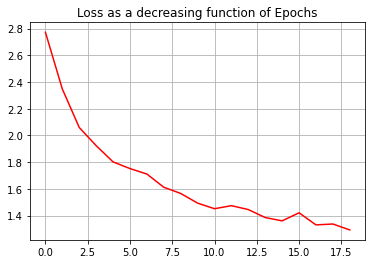

The accuracy of the model is 0.6033333333333334


In [ ]:
criterion = nn.NLLLoss()
n_examples = 100000
plot_every = 5000
learning_rate = 0.005
losses = []

# initialising the RNN
rnn = RNN(n_letters , 128 , len(languages))

total_loss = 0
for n in range(n_examples):
    
    # setting up training example
    # we use random examples because choosing a subset restirct the training of the model
    # it was tried and the results were not the best

    lang = languages[np.random.randint(0,len(languages))]
    input = data[lang][np.random.randint(0 , len(data[lang]))]
    input_tensor = line_to_tensor(input)

    hidden = rnn.init_hidden()
    rnn.zero_grad()

    for j in range(len(input)):
        output , hidden = rnn(input_tensor[j] , hidden)
    
    category_tensor = torch.tensor([languages.index(lang)])
    loss = criterion(output , category_tensor)
    total_loss += loss.item()
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)


    if n % plot_every == 0:
        losses.append(total_loss / plot_every)
        total_loss = 0

plt.plot(losses[1:] , 'r-')
plt.grid(True)
plt.title("Loss as a decreasing function of Epochs")
plt.show()

# Checking for accuracy
accuracy = 0
for n in range(len(testing)):
    example = testing[n]
    input_tensor = line_to_tensor(example[0])

    hidden = rnn.init_hidden()
    for i in range(len(example[0])):
        output , hidden = rnn(input_tensor[i] , hidden)
    if languages.index(example[1]) == torch.argmax(output).item():
        accuracy += 1

print("The accuracy of the model is {}".format(accuracy / len(testing)))

##### Implementing GRU

In [17]:
class GRU(nn.Module):

    def __init__(self , n_input , n_hidden , n_output):
        super().__init__()
        self.hidden_size = n_hidden
        self.gru = nn.GRU(input_size = n_input , hidden_size = n_hidden)
        self.fc = nn.Linear(n_hidden , n_output)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self , input , hidden):
        output , hidden = self.gru(input , hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output , hidden
    
    def init_hidden(self):
        return torch.zeros((1,128))


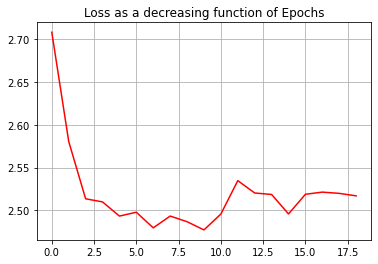

The accuracy of the model is 0.4766666666666667


In [18]:
criterion = nn.CrossEntropyLoss()
n_examples = 100000
plot_every = 5000
# learning_rate = 0.01
losses = []


# initialising the RNN
gru = GRU(n_letters , 128 , len(languages))

optimizer = torch.optim.Adam(params = gru.parameters() ,lr = 0.005)


total_loss = 0
for n in range(n_examples):
    
    # setting up training example
    # we use random examples because choosing a subset restirct the training of the model
    # it was tried and the results were not the best

    lang = languages[np.random.randint(0,len(languages))]
    input = data[lang][np.random.randint(0 , len(data[lang]))]
    input_tensor = line_to_tensor(input)

    hidden = gru.init_hidden()

    gru.zero_grad()

    for j in range(len(input)):
        output , (hidden) = gru(input_tensor[j] , hidden)
    
    category_tensor = torch.tensor([languages.index(lang)])
    loss = criterion(output , category_tensor)
    total_loss += loss.item()
    # loss.backward()
    
    # for p in gru.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)
    
    loss.backward()
    optimizer.step()


    if n % plot_every == 0:
        losses.append(total_loss / plot_every)
        total_loss = 0

plt.plot(losses[1:] , 'r-')
plt.grid(True)
plt.title("Loss as a decreasing function of Epochs")
plt.show()

# Checking for accuracy
accuracy = 0
for n in range(len(testing)):
    example = testing[n]
    input_tensor = line_to_tensor(example[0])

    hidden = gru.init_hidden()
    for i in range(len(example[0])):
        output , (hidden) = gru(input_tensor[i] , hidden)
    if languages.index(example[1]) == torch.argmax(output).item():
        accuracy += 1

print("The accuracy of the model is {}".format(accuracy / len(testing)))

##### Implementing LSTM

In [ ]:
class LSTM(nn.Module):

    def __init__(self , n_input , n_hidden , n_output):
        super().__init__()
        self.hidden_size = n_hidden
        self.cell_size = n_hidden
        self.lstm = nn.LSTM(input_size = n_input , hidden_size = n_hidden)
        self.fc = nn.Linear(n_hidden , n_output)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self , input , hidden , cell):
        output , (hideen , cell) = self.lstm(input , (hidden , cell))
        output = self.fc(output)
        output = self.softmax(output)
        return output , (hidden , cell)
    
    def init_hidden(self):
        return torch.zeros((1,128))

    def init_cell(self):
        return torch.zeros((1,128))


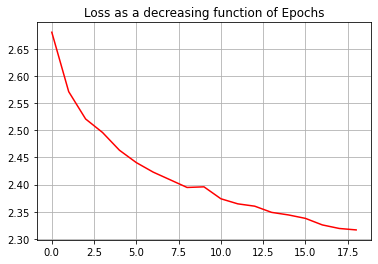

The accuracy of the model is 0.6666666666666666


In [ ]:
criterion = nn.CrossEntropyLoss()
n_examples = 100000
plot_every = 5000
# learning_rate = 0.01
losses = []


# initialising the RNN
lstm = LSTM(n_letters , 128 , len(languages))

optimizer = torch.optim.Adam(params = lstm.parameters() ,lr = 0.005)


total_loss = 0
for n in range(n_examples):
    
    # setting up training example
    # we use random examples because choosing a subset restirct the training of the model
    # it was tried and the results were not the best

    lang = languages[np.random.randint(0,len(languages))]
    input = data[lang][np.random.randint(0 , len(data[lang]))]
    input_tensor = line_to_tensor(input)

    hidden = lstm.init_hidden()
    cell = lstm.init_cell()

    lstm.zero_grad()

    for j in range(len(input)):
        output , (hidden , cell) = lstm(input_tensor[j] , hidden , cell)
    
    category_tensor = torch.tensor([languages.index(lang)])
    loss = criterion(output , category_tensor)
    total_loss += loss.item()
    # loss.backward()
    
    # for p in gru.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)
    
    loss.backward()
    optimizer.step()


    if n % plot_every == 0:
        losses.append(total_loss / plot_every)
        total_loss = 0

plt.plot(losses[1:] , 'r-')
plt.grid(True)
plt.title("Loss as a decreasing function of Epochs")
plt.show()

# Checking for accuracy
accuracy = 0
for n in range(len(testing)):
    example = testing[n]
    input_tensor = line_to_tensor(example[0])

    hidden = lstm.init_hidden()
    cell = lstm.init_cell()
    for i in range(len(example[0])):
        output , (hidden , cell) = lstm(input_tensor[i] , hidden , cell)
    if languages.index(example[1]) == torch.argmax(output).item():
        accuracy += 1

print("The accuracy of the model is {}".format(accuracy / len(testing)))